### Importuri, citire date

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import arviz as az


def remove_outliers(dataframe):
    q_1 = dataframe['mpg'].quantile(0.25)
    q_3 = dataframe['mpg'].quantile(0.75)
    iqr = q_3 - q_1
    lower_bound, upper_bound = q_1 - 1.5 * iqr, q_3 + 1.5 * iqr
    return dataframe[(dataframe['mpg'] >= lower_bound) & (dataframe['mpg'] <= upper_bound)]


df = pd.read_csv('auto-mpg.csv')
df.dropna(inplace=True)


df = df.groupby('horsepower').apply(remove_outliers).reset_index(drop=True)
df = df[df['horsepower'] != '?']


X = df['horsepower'].values.astype(float)
Y = df['mpg'].values.astype(float)


x_sdz = (X - X.mean()) / X.std()
y_sdz = (Y - Y.mean()) / Y.std()


with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=1)
    eps = pm.HalfCauchy('eps', 5)
    miu = pm.Deterministic('miu', alpha + beta * x_sdz)
    y_pred = pm.Normal('y_pred', mu=miu, sigma=eps, observed=y_sdz)
    trace = pm.sample(1000, tune=1000, return_inferencedata=True)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
C:\Users\Ionut\AppData\Local\Temp\ipykernel_2964\3047176710.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('horsepower').apply(remove_outliers).reset_index(drop=True)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, eps]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


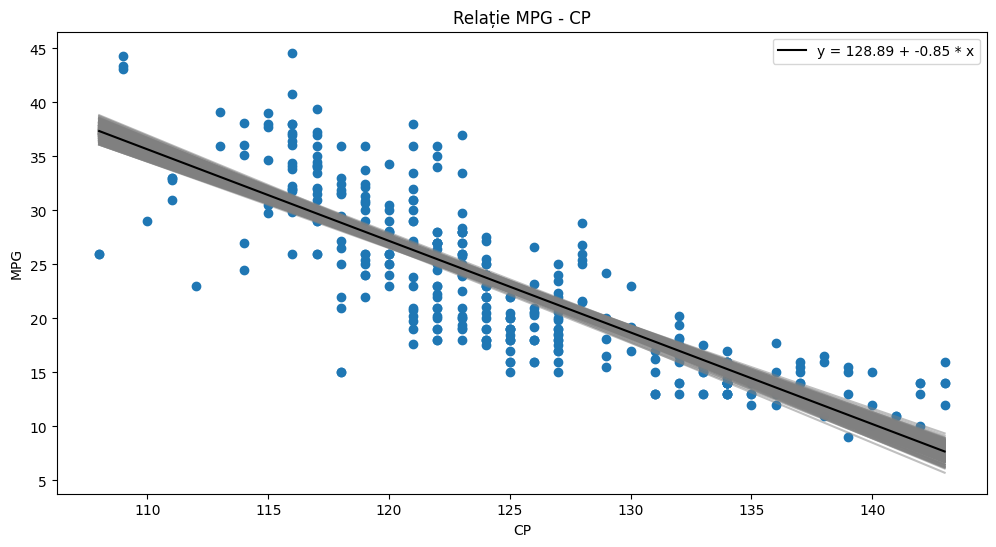

Sampling: [y_pred]


Output()

<Axes: >

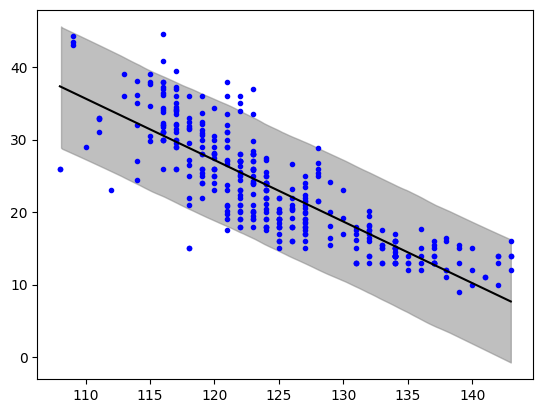

In [2]:
posterior_g = trace.posterior.stack(samples={"chain", "draw"})
alpha_m = posterior_g['alpha'].mean().item()
beta_m = posterior_g['beta'].mean().item()


true_alpha = alpha_m - beta_m * x_sdz.mean()
true_beta = beta_m


X_std = X.std()
X_mean = X.mean()
Y_std = Y.std()
Y_mean = Y.mean()


unstandardized_alpha = alpha_m * Y_std + Y_mean - beta_m * (X_mean * Y_std / X_std)
unstandardized_beta = beta_m * (Y_std / X_std)


draws = range(0, posterior_g.samples.size, 10)
plt.figure(figsize=(12, 6))
plt.plot(X, posterior_g['alpha'][draws].values * Y_std + Y_mean - posterior_g['beta'][draws].values * (X_mean * Y_std / X_std) + posterior_g['beta'][draws].values * (Y_std / X_std) * X[:,None], c='gray', alpha=0.5)
plt.plot(X, unstandardized_alpha + unstandardized_beta * X, c='k',label=f'y = {unstandardized_alpha:.2f} + {unstandardized_beta:.2f} * x')
plt.scatter(X, Y)
plt.title("Relație MPG - CP")
plt.xlabel("CP")
plt.ylabel("MPG")
plt.legend()
plt.show()


ppc = pm.sample_posterior_predictive(trace, model=model)
plt.plot(X, Y, 'b.')
plt.plot(X, unstandardized_alpha + unstandardized_beta * X, c='k',label=f'y = {true_alpha:.2f} + {true_beta:.2f} * x')


y_pred_unstd = ppc.posterior_predictive['y_pred'] * Y_std + Y_mean 
az.plot_hdi(X, y_pred_unstd, hdi_prob=0.95, color='gray')

### Ex 2

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, eps]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


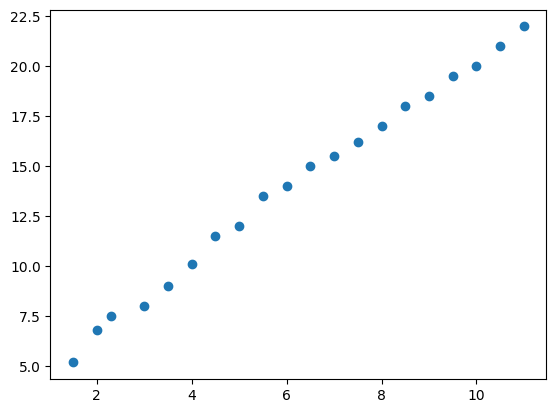

In [3]:
publicity = [1.5, 2.0, 2.3, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0]
sales = [5.2, 6.8, 7.5, 8.0, 9.0, 10.12, 11.5, 12.0, 13.5, 14.0, 15.0, 15.5, 16.2, 17.0, 18.0, 18.5, 19.5, 20.0, 21.0, 22.0]


X = np.array(publicity)
Y = np.array(sales)


plt.scatter(X, Y)


with pm.Model() as model_2:
    alpha_2 = pm.Normal('alpha', mu=0, sigma=10)
    beta_2 = pm.Normal('beta', mu=0, sigma=1)
    eps_2 = pm.HalfCauchy('eps', 5)
    miu_2 = pm.Deterministic('miu', alpha_2 + beta_2 * X)
    y_pred_2 = pm.Normal('y_pred', mu=miu_2, sigma=eps_2, observed=Y)
    
    trace = pm.sample(1000, tune=1000, return_inferencedata=True)

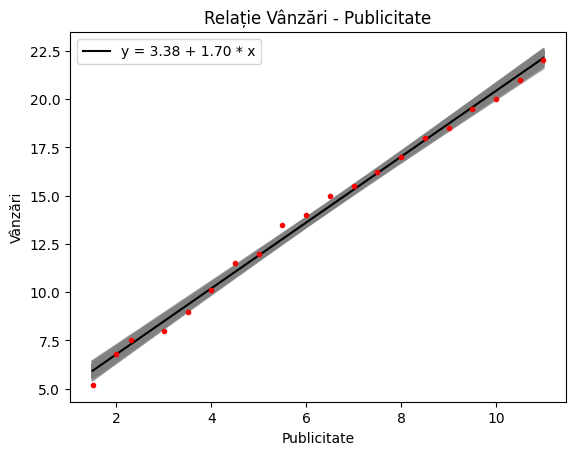

In [6]:
alpha_m = trace.posterior['alpha'].mean().item()
beta_m = trace.posterior['beta'].mean().item()


posterior_g = trace.posterior.stack(samples={"chain", "draw"})
draws = range(0, posterior_g.samples.size, 10)
plt.plot(X, posterior_g['alpha'][draws].values + posterior_g['beta'][draws].values * X[:,None], c='gray', alpha=0.5)
plt.plot(X, alpha_m + beta_m * X, c='k',label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')
plt.title("Relație Vânzări - Publicitate")
plt.xlabel("Publicitate")
plt.ylabel("Vânzări")
plt.plot(X,Y,'r.')
plt.legend()
plt.show()

Sampling: [y_pred]


Output()

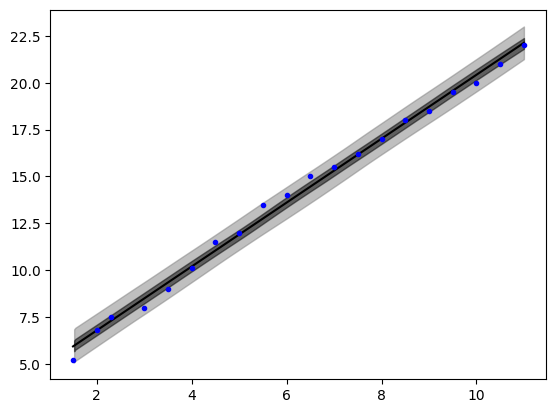

In [5]:
ppc = pm.sample_posterior_predictive(trace, model=model_2)


plt.plot(X, alpha_m + beta_m * X, c='k',label=f'y = {true_alpha:.2f} + {true_beta:.2f} * x')
az.plot_hdi(X, ppc.posterior_predictive['y_pred'], hdi_prob=0.95, color='gray')
az.plot_hdi(X, ppc.posterior_predictive['y_pred'], hdi_prob=0.5, color='black')
plt.plot(X, Y, 'b.')
plt.show()